<a href="https://colab.research.google.com/github/patero22/GNN-Reaserch_project/blob/main/GCN_CSR_id86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Instalacja wymaganych pakietów.
import os
import torch

# Ustawienie środowiskowej zmiennej TORCH na wersję aktualnie używaną przez torch.
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Instalacja torch-scatter z podanego źródła zgodnie z wersją torch.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html

# Instalacja torch-sparse z podanego źródła zgodnie z wersją torch.
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

# Instalacja pytorch_geometric z repozytorium GitHub.
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Definicja funkcji pomocniczej do wizualizacji.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    """
    Funkcja do wizualizacji zanurzenia w przestrzeni 2D za pomocą TSNE.

    Parametry:
    - h: Tensor zanurzeń do wizualizacji.
    - color: Tablica kolorów odpowiadających punktom w tensorze h.
    """

    # Zastosowanie TSNE do zanurzenia w przestrzeni 2D.
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    # Tworzenie wykresu.
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    # Wizualizacja punktów na wykresie.
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 54.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
from torch_geometric.datasets import Planetoid  # Importowanie klasy Planetoid z modułu torch_geometric.datasets
from torch_geometric.transforms import NormalizeFeatures  # Importowanie klasy NormalizeFeatures z modułu torch_geometric.transforms

# Pobieranie zbioru danych Planetoid o nazwie Cora z użyciem transformacji NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()  # Wydruk pustej linii w celu oddzielenia wyników
print(f'Dataset: {dataset}:')  # Wydruk informacji o zbiorze danych
print('======================')  # Wydruk separatora
print(f'Number of graphs: {len(dataset)}')  # Wydruk liczby grafów w zbiorze danych
print(f'Number of features: {dataset.num_features}')  # Wydruk liczby cech w zbiorze danych
print(f'Number of classes: {dataset.num_classes}')  # Wydruk liczby klas w zbiorze danych

data = dataset[0]  # Pobranie pierwszego obiektu grafu z zbioru danych.

print()  # Wydruk pustej linii w celu oddzielenia wyników
print(data)  # Wydruk informacji o pierwszym grafie
print('===========================================================================================================')  # Wydruk separatora

# Zbieranie niektórych statystyk o grafie.
print(f'Number of nodes: {data.num_nodes}')  # Wydruk liczby węzłów w grafie
print(f'Number of edges: {data.num_edges}')  # Wydruk liczby krawędzi w grafie
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')  # Wydruk średniego stopnia węzła w grafie
print(f'Number of training nodes: {data.train_mask.sum()}')  # Wydruk liczby węzłów treningowych
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')  # Wydruk wskaźnika etykiet węzłów treningowych
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # Wydruk informacji o izolowanych węzłach
print(f'Has self-loops: {data.has_self_loops()}')  # Wydruk informacji o pętlach własnych
print(f'Is undirected: {data.is_undirected()}')  # Wydruk informacji o grafie nieskierowanym

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
import torch  # Importuje moduł torch, który jest biblioteką do obliczeń numerycznych w PyTorch.
from torch.nn import Linear  # Importuje klasę Linear z modułu torch.nn, która reprezentuje warstwę liniową.
import torch.nn.functional as F  # Importuje funkcje aktywacji i inne funkcje pomocnicze z modułu torch.nn.functional.

class MLP(torch.nn.Module):  # Definiuje klasę MLP (Multi-Layer Perceptron), która dziedziczy po klasie torch.nn.Module.
    def __init__(self, hidden_channels):  # Definiuje konstruktor klasy MLP z parametrem hidden_channels.
        super().__init__()  # Wywołuje konstruktor klasy nadrzędnej (torch.nn.Module).
        torch.manual_seed(12345)  # Ustawia ziarno generatora liczb losowych w PyTorch dla powtarzalności wyników.
        self.lin1 = Linear(dataset.num_features, hidden_channels)  # Inicjalizuje pierwszą warstwę liniową z dataset.num_features wejściami i hidden_channels wyjściami.
        self.lin2 = Linear(hidden_channels, dataset.num_classes)  # Inicjalizuje drugą warstwę liniową z hidden_channels wejściami i dataset.num_classes wyjściami.

    def forward(self, x):  # Definiuje metodę forward dla przekazywania danych przez model.
        x = self.lin1(x)  # Przekazuje dane przez pierwszą warstwę liniową.
        x = x.relu()  # Aktywuje dane przy użyciu funkcji ReLU (Rectified Linear Unit).
        x = F.dropout(x, p=0.5, training=self.training)  # Stosuje warstwę dropout do danych z prawdopodobieństwem 0.5 w czasie treningu.
        x = self.lin2(x)  # Przekazuje dane przez drugą warstwę liniową.
        return x  # Zwraca przetworzone dane.

model = MLP(hidden_channels=16)  # Tworzy instancję modelu MLP z 16 ukrytymi kanałami.
print(model)  # Wyświetla architekturę modelu.



MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [9]:

from torch_geometric.nn import GCNConv  # Importuje klasę GCNConv z modułu torch_geometric.nn, która reprezentuje warstwę konwolucyjną GCN.

class GCN(torch.nn.Module):  # Definiuje klasę GCN, która dziedziczy po klasie torch.nn.Module.
    def __init__(self, hidden_channels):  # Definiuje konstruktor klasy GCN z parametrem hidden_channels.
        super().__init__()  # Wywołuje konstruktor klasy nadrzędnej (torch.nn.Module).
        torch.manual_seed(1234567)  # Ustawia ziarno generatora liczb losowych w PyTorch dla powtarzalności wyników.
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)  # Inicjalizuje pierwszą warstwę konwolucyjną GCN z dataset.num_features wejściami i hidden_channels wyjściami.
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)  # Inicjalizuje drugą warstwę konwolucyjną GCN z hidden_channels wejściami i dataset.num_classes wyjściami.

    def forward(self, x, edge_index):  # Definiuje metodę forward dla przekazywania danych przez model.
        x = self.conv1(x, edge_index)  # Przeprowadza konwolucję na danych wejściowych x z wykorzystaniem pierwszej warstwy konwolucyjnej GCN.
        x = x.relu()  # Aktywuje dane przy użyciu funkcji ReLU (Rectified Linear Unit).
        x = F.dropout(x, p=0.5, training=self.training)  # Stosuje warstwę dropout do danych z prawdopodobieństwem 0.5 w czasie treningu.
        x = self.conv2(x, edge_index)  # Przeprowadza konwolucję na danych wyjściowych z pierwszej warstwy konwolucyjnej x z wykorzystaniem drugiej warstwy konwolucyjnej GCN.
        return x  # Zwraca przetworzone dane.

model = GCN(hidden_channels=16)  # Tworzy instancję modelu GCN z 16 ukrytymi kanałami.
print(model)  # Wyświetla architekturę modelu.

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

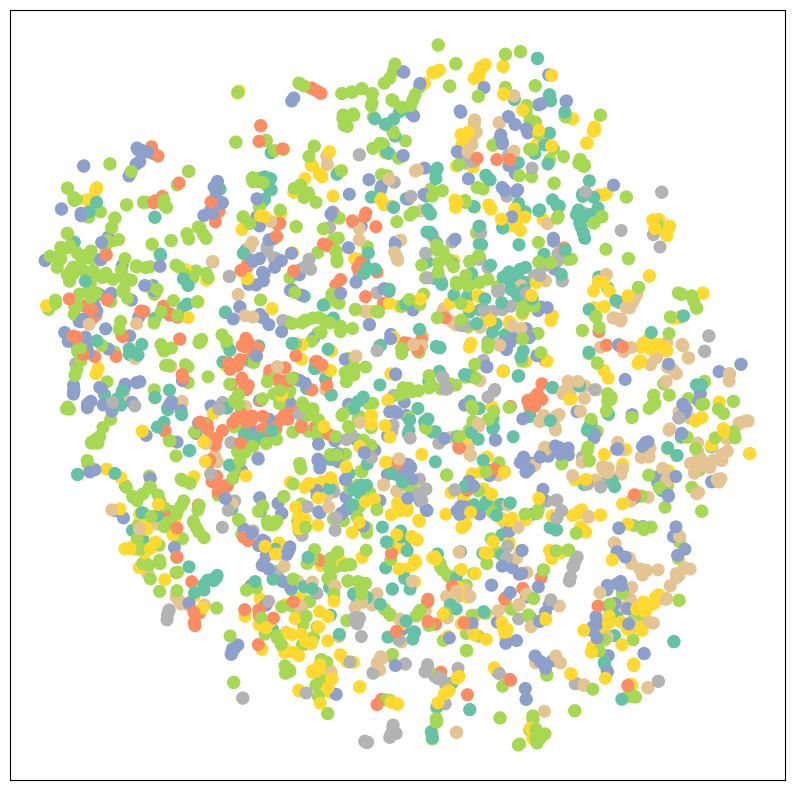

In [10]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [12]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

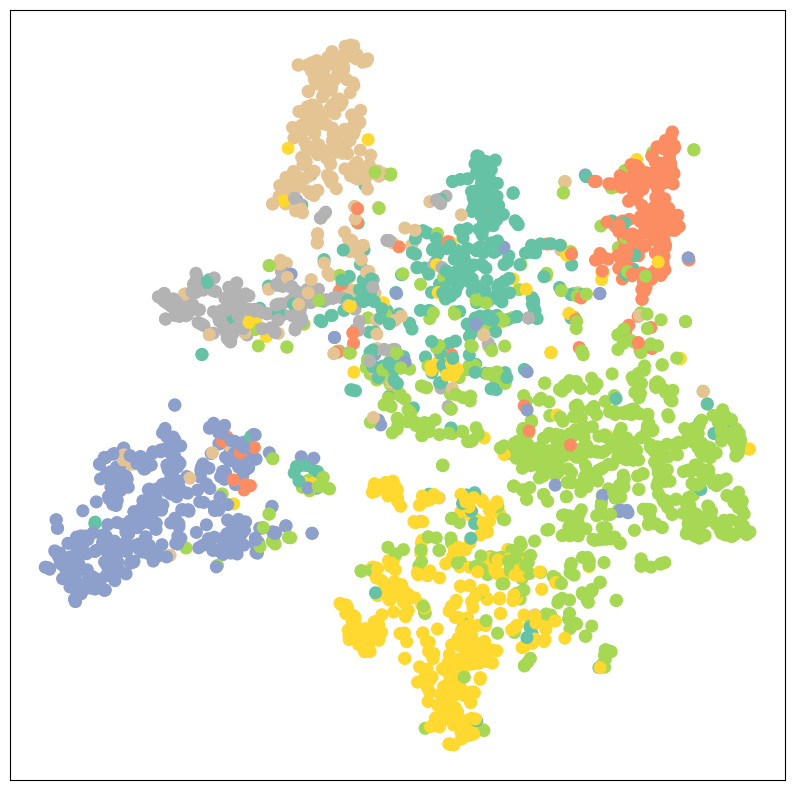

In [13]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

---

# GCN WITH CSR

In [20]:
import torch  # Importuje moduł torch
from torch_geometric.datasets import Planetoid  # Importuje klasę Planetoid z modułu torch_geometric.datasets
from torch_geometric.nn import GCNConv  # Importuje klasę GCNConv z modułu torch_geometric.nn
import torch.nn.functional as F  # Importuje moduł torch.nn.functional jako F
from scipy.sparse import coo_matrix  # Importuje klasę coo_matrix z modułu scipy.sparse
from torch_sparse import coalesce  # Importuje funkcję coalesce z modułu torch_sparse


# Wczytanie zbioru danych Planetoid o nazwie Cora
dataset = Planetoid(root='data/Planetoid', name='Cora')

# Przekształcenie macierzy sąsiedztwa do formatu CSR
adj_coo = dataset[0].edge_index  # Pobranie macierzy sąsiedztwa w formacie COO

# Określenie liczby wierszy i kolumn w macierzy CSR
m = int(adj_coo.max()) + 1
n = m

# Konwersja do formatu CSR i zmniejszenie duplikatów
adj_csr = coalesce(adj_coo, torch.ones(adj_coo.shape[1]), m, n)

# Definicja modelu GCN w formacie CSR
class GCN_CSR(torch.nn.Module):
    def __init__(self, hidden_channels):  # Inicjalizacja klasy
        super().__init__()  # Wywołanie konstruktora klasy nadrzędnej
        torch.manual_seed(1234567)  # Ustawienie ziarna losowości
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)  # Inicjalizacja pierwszej warstwy konwolucyjnej GCN
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)  # Inicjalizacja drugiej warstwy konwolucyjnej GCN

    def forward(self, x, edge_index):  # Przejście do przodu przez model
        x = F.dropout(x, p=0.6, training=self.training)  # Wykonanie dropoutu
        x = self.conv1(x, edge_index)  # Przekazanie danych przez pierwszą warstwę GCN
        x = F.elu(x)  # Aktywacja danych
        x = F.dropout(x, p=0.6, training=self.training)  # Wykonanie dropoutu
        x = self.conv2(x, edge_index)  # Przekazanie danych przez drugą warstwę GCN
        return x  # Zwrócenie wyników

# Inicjalizacja modelu GCN w formacie CSR
model = GCN_CSR(hidden_channels=16)

# Definicja optymalizatora i kryterium straty
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Funkcja trenowania modelu
def train():  # Definicja funkcji
    model.train()  # Ustawienie modelu w tryb treningowy
    optimizer.zero_grad()  # Wyzerowanie gradientów
    out = model(data.x, adj_csr)  # Przekazanie danych przez model
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Obliczenie straty
    loss.backward()  # Wsteczna propagacja błędu
    optimizer.step()  # Aktualizacja wag
    return loss  # Zwrócenie straty

def test():
    model.eval()
    out = model(data.x, adj_csr)
    if out is None:  # Sprawdzenie, czy out nie jest None
        print("Błąd: Brak danych wyjściowych z modelu")
        return 0.0  # Zwrócenie zerowej dokładności w przypadku braku danych wyjściowych

    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


# Trening i testowanie modelu
for epoch in range(1, 101):  # Pętla trenowania
    loss = train()  # Wywołanie funkcji trenowania
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')  # Wydruk epoki i straty

test_acc = test()  # Wywołanie funkcji testowania
print(f'Test Accuracy: {test_acc:.4f}')  # Wydruk dokładności testowania


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

In [22]:
# Importowanie wymaganych bibliotek
import os
import torch
from torch_geometric.datasets import Planetoid
from torch_sparse import coalesce

# Ustawienie środowiskowej zmiennej TORCH na wersję aktualnie używaną przez torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Instalacja wymaganych pakietów
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Definicja funkcji pomocniczej do wizualizacji
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Pobranie zbioru danych Planetoid o nazwie Cora
dataset = Planetoid(root='data/Planetoid', name='Cora')

# Pobranie pierwszego obiektu grafu z zbioru danych
data = dataset[0]

# Przekształcenie macierzy sąsiedztwa do formatu CSR
adj_coo = dataset[0].edge_index  # Pobranie macierzy sąsiedztwa w formacie COO

# Określenie liczby wierszy i kolumn w macierzy CSR
m = int(adj_coo.max()) + 1
n = m

# Konwersja do formatu CSR i zmniejszenie duplikatów
adj_csr = coalesce(adj_coo, torch.ones(adj_coo.shape[1]), m, n)

# Tworzenie modelu GCN w formacie CSR
from torch_geometric.nn import GCNConv

class GCN_CSR(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN_CSR(hidden_channels=16)
print(model)

# Optymalizacja, trening i testowanie modelu GCN w formacie CSR
import torch.nn.functional as F
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, adj_csr)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, adj_csr)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

# Trenowanie modelu
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Testowanie modelu
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
GCN_CSR(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

In [25]:
# Importuj biblioteki
import os
import torch
from torch_geometric.datasets import Planetoid
from torch_sparse import coalesce

# Ustaw środowiskową zmienną TORCH na aktualną wersję używaną przez torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Instaluj wymagane pakiety
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Definiuj funkcję wizualizacji
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Pobierz zbiór danych Planetoid o nazwie Cora
dataset = Planetoid(root='data/Planetoid', name='Cora')

# Pobierz pierwszy obiekt grafu z zbioru danych
data = dataset[0]

# Przekształcenie macierzy sąsiedztwa do formatu CSR
adj_coo = dataset[0].edge_index  # Pobranie macierzy sąsiedztwa w formacie COO

# Określenie liczby wierszy i kolumn w macierzy CSR
m = int(adj_coo.max()) + 1
n = m

# Konwersja do formatu CSR i zmniejszenie duplikatów
adj_csr = coalesce(adj_coo, torch.ones(adj_coo.shape[1]), m, n)

# Twórz model GCN w formacie CSR
from torch_geometric.nn import GCNConv

class GCN_CSR(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN_CSR(hidden_channels=16)
print(model)

# Optymalizuj, trenuj i testuj model GCN w formacie CSR
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

# Trenuj model
for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Testuj model
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
GCN_CSR(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Test Accuracy: 0.8000
